In [3]:
# !pip install imageio

In [27]:
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist

In [5]:
(train_images, train_labels), (_, _) = mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# normalize images to [-1,1]
train_images = (train_images - 127.5) / 127.5

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

train_df = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
train_df

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [14]:
def build_gen_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7,7,256)
    
    model.add(Conv2DTranspose(128,(5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7,7,128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64,(5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14,14,64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None, 28,28,1)
    
    return model

In [15]:
generator = build_gen_model()

In [16]:
noise = tf.random.normal([1,100])
gen_image = generator(noise, training=False)

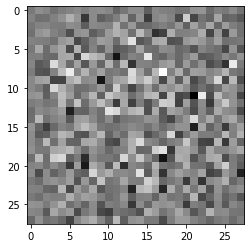

In [18]:
plt.imshow(gen_image[0,:,:,0], cmap="gray")

In [19]:
def build_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=(28,28,1)))
    model.add(LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(1))
    
    return model

In [20]:
discriminator = build_discriminator_model()

In [21]:
pred = discriminator(gen_image)

In [22]:
pred

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00074829]], dtype=float32)>

In [23]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
# Generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [26]:
gen_optimizer = tf.keras.optimizers.Adam()
dis_optimizer = tf.keras.optimizers.Adam()

In [28]:
# save checkpoints
checkpoint_dir = "./training_checkpoints"
ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer,
                                dis_optimizer=dis_optimizer,
                                generator = generator,
                                discriminator = discriminator)

In [29]:
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        # generating fake images
        gen_images = generator(noise)
        
        # pass original images to discriminator
        real_output = discriminator(images, training=True)
        # pass fake generated images to discriminator
        fake_output = discriminator(gen_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)
        
    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_dis = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradient_gen, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradient_dis, discriminator.trainable_variables))

In [30]:
def generate_and_save(model, epoch, test_input):
    prediction = model(test_input, training=False)
    figure = plt.figure(figsize=(4,4))
    for i in range(prediction.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
        
    plt.savefig("img_at_epoch_{}.png".format(epoch))
    plt.show()

In [31]:
def train(dataset, epochs):
    seed = tf.random.normal([16, noise_dim])
    for epoch in range(epochs):
        start = time.time()
        
        for img_batch in dataset:
            train_step(img_batch)
            
        generate_and_save(generator, epoch + 1, seed)
        
        checkpoint.save(file_prefix=ckpt_prefix)
        end = time.time()
        total = end - start
        print("Time for epoch {} is {} sec".format(epoch + 1, total))
        
    generate_and_save(generator, epochs, seed)

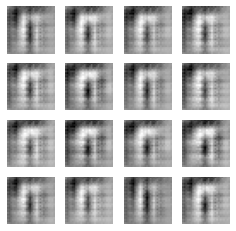

Time for epoch 1 is 194.9281587600708 sec


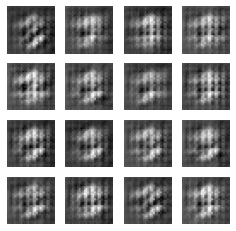

Time for epoch 2 is 206.01261234283447 sec


KeyboardInterrupt: 

In [32]:
train(train_df, epochs=10)